In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/raw_data2.zip'
extract_path = '/content/raw_data2'

os.makedirs(extract_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted files to: {extract_path}")
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}, Subdirectories: {dirs}, Files: {len(files)}")

Extracted files to: /content/raw_data2
Directory: /content/raw_data2, Subdirectories: ['raw_data'], Files: 0
Directory: /content/raw_data2/raw_data, Subdirectories: ['no_nsfw', 'nsfw'], Files: 0
Directory: /content/raw_data2/raw_data/no_nsfw, Subdirectories: [], Files: 5550
Directory: /content/raw_data2/raw_data/nsfw, Subdirectories: [], Files: 5420


In [ ]:
data_dir = os.path.join(extract_path, "raw_data")

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Load the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check class names
print(f"Class names: {train_ds.class_names}")

Found 10970 files belonging to 2 classes.
Using 8776 files for training.
Found 10970 files belonging to 2 classes.
Using 2194 files for validation.
Class names: ['no_nsfw', 'nsfw']


In [ ]:
os.makedirs('./cache_dir', exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache('./cache_dir/train_cache.tf-data').prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache('./cache_dir/val_cache.tf-data').prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model (we will fine-tune later)
base_model.trainable = False

# Define data augmentation for the training set
data_augmentation = Sequential([
    tf.keras.layers.RandomZoom(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.25)
])

# Define the full model
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [ ]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[Recall(name='recall'), 'accuracy', AUC(name='auc')])

In [ ]:
# Learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 1e-3
    drop_rate = 0.5
    epoch_drop = 5.0
    lr = initial_lr * (drop_rate ** (epoch // epoch_drop))
    return lr

lr_callback = LearningRateScheduler(lr_schedule)

# Early stopping to monitor recall and stop training if it stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

In [ ]:
# Train the model for initial training
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          callbacks=[lr_callback, early_stopping])

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.8208 - auc: 0.8920 - loss: 1.5416 - recall: 0.8244 - val_accuracy: 0.8268 - val_auc: 0.9107 - val_loss: 0.6367 - val_recall: 0.7985 - learning_rate: 0.0010
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - accuracy: 0.8603 - auc: 0.9335 - loss: 0.5330 - recall: 0.8661 - val_accuracy: 0.8127 - val_auc: 0.9236 - val_loss: 0.5290 - val_recall: 0.9347 - learning_rate: 0.0010
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 228ms/step - accuracy: 0.8596 - auc: 0.9323 - loss: 0.4363 - recall: 0.8638 - val_accuracy: 0.8273 - val_auc: 0.9300 - val_loss: 0.4664 - val_recall: 0.7187 - learning_rate: 0.0010
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.8592 - auc: 0.9315 - loss: 0.4071 - recall: 0.8532 - val_accuracy: 0.8355 - val_auc: 0.9206 - val_loss: 0.4508 - val_recall: 0.7541 - learning_rate: 0.0010
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 60s 217ms/step - accuracy: 0.8636 - auc: 0.9369 - loss: 0.38

In [ ]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,301 (10.50 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

 Optimizer params: 328,708 (1.25 MB)

In [ ]:
model.save('model_initial.h5', save_format='h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_initial.h5')

# Unfreeze some layers for fine-tuning
base_model = model.get_layer('mobilenetv2_1.00_224')
base_model.trainable = True

fine_tune_at = 90  # Unfreeze from layer 100 onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False



optimizer = Adam(learning_rate=1e-4, weight_decay=1e-5)
class_weights = {0: 1.0, 1: 2.0}
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Recall(name='recall'), 'accuracy', AUC(name='auc')])

In [ ]:
def lr_schedule(epoch, initial_lr=1e-4, total_epochs=50):
    # Cosine Annealing
    lr = initial_lr * (1 + np.cos(np.pi * epoch / total_epochs)) / 2
    return lr

In [ ]:
# Early stopping for fine tuning
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [ ]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          class_weight=class_weights,
          callbacks=[lr_callback, early_stopping])

Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - accuracy: 0.8666 - auc: 0.9402 - loss: 0.4857 - recall: 0.9021 - val_accuracy: 0.6659 - val_auc: 0.7726 - val_loss: 2.4641 - val_recall: 0.3421 - learning_rate: 0.0010
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 57s 205ms/step - accuracy: 0.9159 - auc: 0.9772 - loss: 0.2961 - recall: 0.9492 - val_accuracy: 0.6449 - val_auc: 0.8420 - val_loss: 1.7740 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 47s 171ms/step - accuracy: 0.9318 - auc: 0.9825 - loss: 0.2538 - recall: 0.9558 - val_accuracy: 0.5132 - val_auc: 0.6076 - val_loss: 3.6131 - val_recall: 0.9991 - learning_rate: 0.0010
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 48s 175ms/step - accuracy: 0.9342 - auc: 0.9848 - loss: 0.2390 - recall: 0.9641 - val_accuracy: 0.8345 - val_auc: 0.9008 - val_loss: 0.7583 - val_recall: 0.8966 - learning_rate: 0.0010
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 56s 204ms/step - accuracy: 0.9395 - auc: 0.9877 - loss: 0.21

In [ ]:
model.save('model.h5')

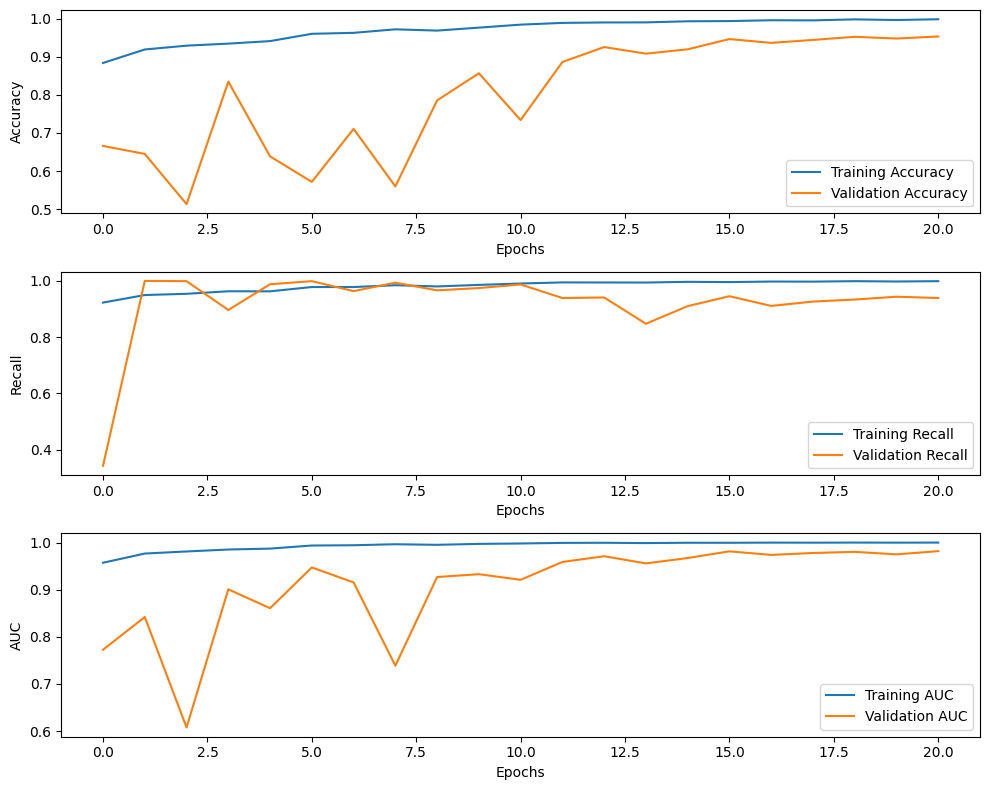

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Accuracy plot
plt.subplot(3, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Recall plot
plt.subplot(3, 1, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
if 'auc' in history.history:
    plt.subplot(3, 1, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Safe


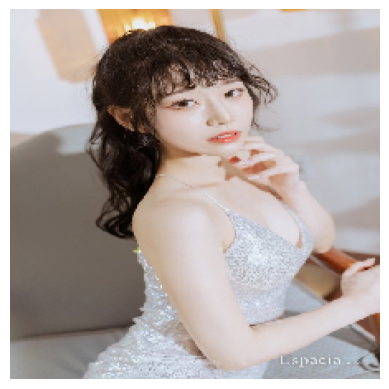

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

model = load_model('model.h5')

# Parameters
img_height = 224
img_width = 224

# Load and preprocess the test image
test_image_path = '3.jpeg'
img = load_img(test_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)
print("Prediction:", "NSFW" if prediction[0][0] > 0.5 else "Safe")

# Show the image
plt.imshow(img)
plt.axis('off')
plt.show()